In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from models.dilated_conv import DilatedConvEncoder
from models.embedding import Embedding
from models.encoder import TCNEncoder, RNNEncoder
from models.dragonnet import Dragonnet
from models.siamese import SiameseNetwork

from dataset.dataset import UpliftDataset

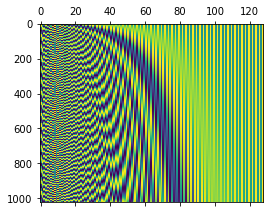

In [2]:
emb = Embedding(100, 128, 1024)
plt.matshow(emb.position_embeddings.weight.detach().numpy(), aspect=1/10)

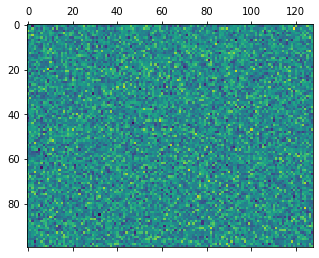

In [3]:
plt.matshow(emb.input_embeddings[0].weight.detach().numpy())

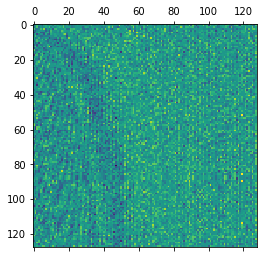

In [4]:
inputs = torch.randint(0, 50, (1, 128))
embeddings = emb(inputs)
plt.matshow(embeddings[0].detach().numpy(), aspect='auto')

In [5]:
DATA_DIR = "/opt/datasets/thebackend/v0.1/20220416-120000_2097/"

raw_datasets = UpliftDataset(DATA_DIR)
print(len(raw_datasets))

2034


In [6]:
train_set, valid_set = raw_datasets.split_valid(by='user', val_ratio=0.2, random_state=42)

gamer_ids = raw_datasets.info['X'].apply(lambda x: x.split('_')[0])

print(f"Lenght of train set: {len(train_set)} and validation set: {len(valid_set)}")
print(f"Unique users in train set: {len(gamer_ids[train_set.indices].unique())} and validation set: {len(gamer_ids[valid_set.indices].unique())}")

Group 1: 587 users.
Group 2: 425 users.
Group 3: 511 users.
Lenght of train set: 1625 and validation set: 409
Unique users in train set: 1217 and validation set: 306


In [7]:
example = train_set[0]
print(f"Timestamp: {example['timestamp'].shape}, X: {example['X'].shape}, t: {example['t']}, y: {example['y']}")

Timestamp: torch.Size([1311, 4]), X: torch.Size([1311, 2]), t: 1.0, y: 0.0


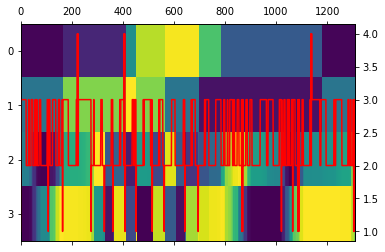

In [8]:
fig, ax = plt.subplots(1, 1)
ax.matshow(example['timestamp'].detach().numpy().T, aspect='auto')
ax_ = ax.twinx()
ax_.plot(example['X'][:, 0].detach().numpy().T, color='red')
fig.show()

In [9]:
# It handles multiple categorical features. 
# You just provide the number of unique values for each feature in a list and according dimensions in another list.
emb = Embedding([35, 4], [16, 4], 1024)

time = example['timestamp'].unsqueeze(0)[:, :1024, :]
ftrs = example['X'].unsqueeze(0)[:, :1024, :]
ftrs = emb(ftrs)

ftrs = torch.cat([time, ftrs], dim=2)
print(ftrs.shape)

torch.Size([1, 1024, 24])


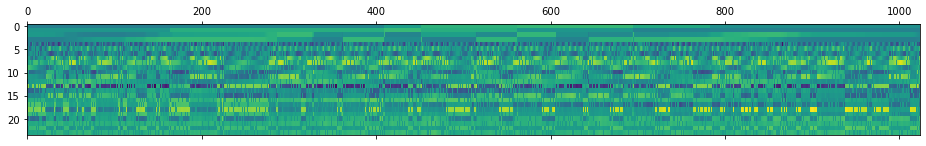

In [10]:
plt.matshow(ftrs.detach().numpy()[0].T, aspect='auto')

In [11]:
encoder = DilatedConvEncoder(24, [128] * 10, 3, 0.2)
out = encoder(ftrs.transpose(1, 2)) # (B, D, L)
out.shape

torch.Size([1, 128, 1024])

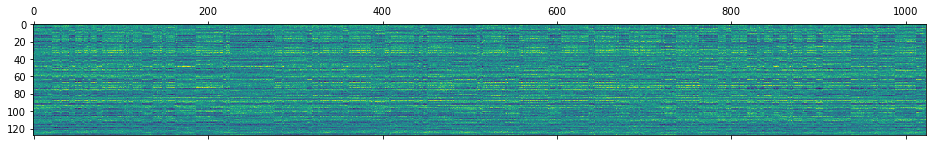

In [12]:
plt.matshow(out[0].detach().numpy(), aspect='auto')

In [13]:
model = TCNEncoder(24, 128, 10, 0.2, 'last') # backbone
out = model(ftrs)
out.shape

torch.Size([1, 128])

In [14]:
model = RNNEncoder(24, 128, 2, 0.2, 'last') # backbone
out = model(ftrs)
out.shape

torch.Size([1, 128])

In [15]:
net = Dragonnet(model, 128)
out = net(ftrs)
out

{'t': tensor([0.5086], grad_fn=<SqueezeBackward1>),
 'y1': tensor([0.4452], grad_fn=<SqueezeBackward1>),
 'y0': tensor([0.4894], grad_fn=<SqueezeBackward1>)}

In [16]:
net = SiameseNetwork(model, 128)
out = net(ftrs)
out

{'y1': tensor([0.1756], grad_fn=<SqueezeBackward1>),
 'y0': tensor([0.1837], grad_fn=<SqueezeBackward1>)}